# Metagenomic-based Diagnostic for Sepsis (Karius Dataset)

In [1]:
import xgboost
import shap
print(xgboost.__version__, shap.__version__)

0.90 0.34.0


In [2]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results/maxi_silva'

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [3]:
maxi_df = pd.read_csv(datasets / 'kapusta_grumaz_karius_genus_maxi_raw.csv')
silva_df = pd.read_csv(datasets / 'kapusta_grumaz_karius_genus_raw.csv')

# Remove NTCs
maxi_df = maxi_df.loc[maxi_df.y != 'ntc', :]
silva_df = silva_df.loc[silva_df.y != 'ntc', :]

display(maxi_df.head())
display(silva_df.head())

X_maxi = maxi_df.drop('y', axis=1).copy()
X_silva = silva_df.drop('y', axis=1).copy()

assert maxi_df.y.equals(silva_df.y)
y = maxi_df.y.copy()

,y,Bifidobacterium,Alloscardovia,Gardnerella,Arthrobacter,Kocuria,Cellulomonas,Brevibacterium,Rhodoluna,Agrococcus,...,Komagataeibacter,Planomicrobium,Tropicimonas,Humibacillus,Parvibaculum,Romboutsia,Thiohalocapsa,Magnetospira,Mobilicoccus,Bilophila
0,healthy,36216.0,0.0,1.0,0.0,0.0,98.0,19.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,septic,268.0,0.0,0.0,1.0,0.0,19.0,5.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,healthy,30576.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,healthy,26702.0,7.0,4.0,8.0,1.0,36.0,29.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,healthy,20482.0,0.0,1.0,1.0,1.0,4.0,24.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,y,Bifidobacterium,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Micrococcus,Pseudarthrobacter,Microbacterium,...,Slackia,Mumia,Thermomonospora,Ilumatobacter,Marinibacterium,Maricaulis,Stella,Eoetvoesia,Bilophila,Paeniclostridium
0,healthy,42891.0,1.0,14.0,1.0,3.0,0.0,15.0,1.0,7.0,...,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
1,septic,730.0,0.0,48.0,9.0,10.0,1.0,20.0,5.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,healthy,36074.0,3.0,6.0,56.0,3.0,0.0,21.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,healthy,44094.0,0.0,59.0,10.0,21.0,3.0,66.0,40.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,healthy,26958.0,0.0,6.0,1.0,0.0,0.0,16.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Binary encode y
y.loc[y == 'septic'] = 1
y.loc[y == 'healthy'] = 0
y = y.astype('int')

In [5]:
n_splits = 10

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'Septic': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'Healthy': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Septic,Healthy
Train fold,207,188
Test fold,23,20


## Nested CV for hyperparameter optimisation

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

In [7]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='roc_auc',
                               n_iter=1000,
                               n_jobs=70, 
                               cv=inner_cv, 
                               verbose=0)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


### Optimise and evaluate models trained on dirty data

In [8]:
maxi_results, maxi_params = optimise_evaluate(X_maxi, y)
# raw_params = {'subsample': 0.5263157894736842, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 96, 'max_depth': 2, 'gamma': 1.8421052631578947, 'colsample_bytree': 0.19473684210526315}
silva_results, silva_params = optimise_evaluate(X_silva, y)
# RA_params = {'subsample': 0.4789473684210527, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 255, 'max_depth': 1, 'gamma': 0.7894736842105263, 'colsample_bytree': 0.4}


{'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 230, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.1}
{'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.1473684210526316}


## Estimates of test error

In [9]:
metric_df = pd.DataFrame({'MaxiKraken2': maxi_results, 'Silva': silva_results}).round(3).T
display(metric_df)

,test_precision,test_recall,test_F1,test_AUROC
MaxiKraken2,0.955,0.943,0.948,0.987
Silva,0.950,0.939,0.944,0.982


562


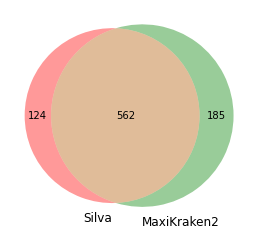

In [16]:
from matplotlib_venn import venn2
A = set(silva_df.columns)
B = set(maxi_df.columns)
print(len(A.intersection(B)))

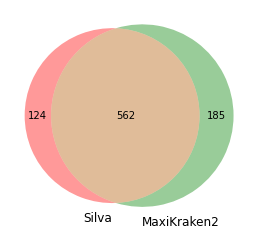

In [18]:
%matplotlib inline
venn2([A, B], set_labels=["Silva", "MaxiKraken2"])
plt.savefig(results / 'pooled_neat_venn.png', dpi=300, format='png', bbox_inches='tight')